# EEG emotion recognition

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.signal as signal
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (15, 7)
plt.rcParams['image.cmap'] = 'summer'

## Dataset extraction

Let us explore more about our dataset.

In [2]:
# read data
data = pd.read_csv('./emotions.csv')
data.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


As we can see, the dataset contains a lot of features, such as mean values, minimal and maximal ones, etc.

Divide data into labels and features.

In [3]:
data_labels = data['label']
data.drop('label', axis = 1, inplace=True)

In [4]:
data_fft = data.loc[:,'fft_0_b':'fft_749_b']
data_fft.head()

,fft_0_b,fft_1_b,fft_2_b,fft_3_b,fft_4_b,fft_5_b,fft_6_b,fft_7_b,fft_8_b,fft_9_b,...,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b
0,-508.0,438.00,-222.00,-222.00,438.00,143.0,59.40,5.05,5.05,59.40,...,74.3,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00
1,126.0,-4.00,7.42,7.42,-4.00,81.6,-22.30,35.30,35.30,-22.30,...,130.0,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57
2,-85.9,361.00,-62.20,-62.20,361.00,-558.0,684.00,-152.00,-152.00,684.00,...,-534.0,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00
3,69.5,3.89,12.10,12.10,3.89,-188.0,274.00,-200.00,-200.00,274.00,...,-183.0,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40
4,226.0,-27.40,147.00,147.00,-27.40,301.0,-8.48,138.00,138.00,-8.48,...,114.0,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60


In [5]:
data_fft.describe()

,fft_0_b,fft_1_b,fft_2_b,fft_3_b,fft_4_b,fft_5_b,fft_6_b,fft_7_b,fft_8_b,fft_9_b,...,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b
count,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,...,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000
mean,-44.697430,117.945707,-61.129237,-61.129237,117.945707,-19.942029,102.733410,-52.112550,-52.112550,102.733410,...,-22.938971,104.946111,-51.973647,-51.973647,104.946111,-6.934144,95.104886,-49.061255,-49.061255,95.104886
std,282.126882,202.274870,102.957227,102.957227,202.274870,303.924090,214.518033,115.677682,115.677682,214.518033,...,298.034311,212.532721,112.160233,112.160233,212.532721,281.040552,203.194976,106.486317,106.486317,203.194976
min,-1160.000000,-647.000000,-483.000000,-483.000000,-647.000000,-1290.000000,-1050.000000,-497.000000,-497.000000,-1050.000000,...,-1180.000000,-921.000000,-504.000000,-504.000000,-921.000000,-1160.000000,-1010.000000,-521.000000,-521.000000,-1010.000000
25%,-173.250000,-5.857500,-108.000000,-108.000000,-5.857500,-120.250000,-10.500000,-97.025000,-97.025000,-10.500000,...,-106.500000,-8.365000,-92.900000,-92.900000,-8.365000,-102.500000,-8.837500,-87.150000,-87.150000,-8.837500
50%,71.950000,14.550000,-29.550000,-29.550000,14.550000,86.550000,10.700000,-21.200000,-21.200000,10.700000,...,83.850000,12.150000,-21.800000,-21.800000,12.150000,89.700000,13.400000,-24.100000,-24.100000,13.400000
75%,140.000000,231.000000,5.715000,5.715000,231.000000,154.250000,179.000000,13.000000,13.000000,179.000000,...,154.000000,177.000000,12.025000,12.025000,177.000000,153.000000,149.250000,10.925000,10.925000,149.250000
max,963.000000,885.000000,975.000000,975.000000,885.000000,1320.000000,904.000000,1800.000000,1800.000000,904.000000,...,1070.000000,843.000000,1490.000000,1490.000000,843.000000,1180.000000,888.000000,1670.000000,1670.000000,888.000000


## Signal generation
Unfortunately, the dataset does not contain EEG signals.

Let us create inverse Fourier transform for each of the fft row.

In [6]:
rows = data_fft.values
iffts = []

duration = 1
fs = rows[0].shape[0] / duration

time = np.arange(0, duration, 1 / fs)
freq = np.arange(0., fs, 1 / duration)

for row in rows:
    iffts.append(np.fft.ifft(row))

/home/sophmintaii/.local/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


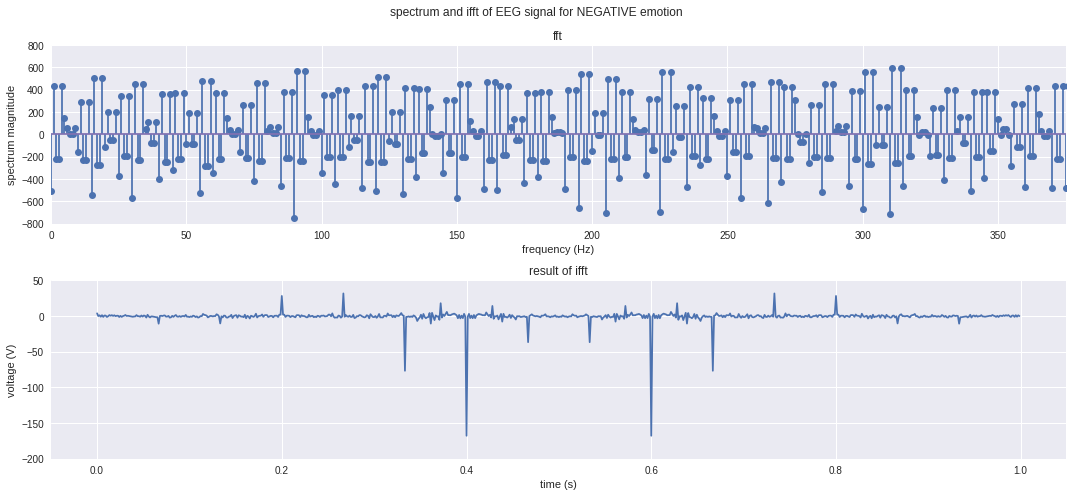

In [7]:
plt.rcParams["figure.figsize"] = (15, 7)
fig, axs = plt.subplots(2, 1)
fig.suptitle('spectrum and ifft of EEG signal for NEGATIVE emotion')

axs[0].stem(freq, rows[0])
axs[0].set_xlabel("frequency (Hz)")
axs[0].set_ylabel("spectrum magnitude")
axs[0].title.set_text("fft")
axs[0].set_xlim([0, fs / 2])
axs[0].set_ylim([-800, 800])

axs[1].plot(time, iffts[0])
axs[1].set_xlabel("time (s)")
axs[1].set_ylabel("voltage (V)")
axs[1].title.set_text("result of ifft")
axs[1].set_ylim([-200, 50])

plt.tight_layout()
plt.show()

/home/sophmintaii/.local/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


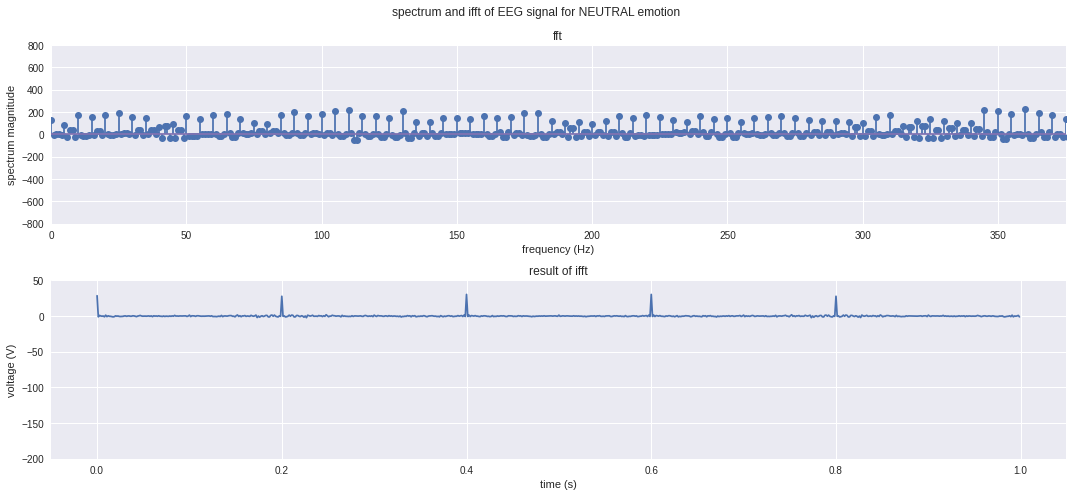

In [8]:
plt.rcParams["figure.figsize"] = (15, 7)
fig, axs = plt.subplots(2, 1)
fig.suptitle('spectrum and ifft of EEG signal for NEUTRAL emotion')

axs[0].stem(freq, rows[1])
axs[0].set_xlabel("frequency (Hz)")
axs[0].set_ylabel("spectrum magnitude")
axs[0].title.set_text("fft")
axs[0].set_xlim([0, fs / 2])
axs[0].set_ylim([-800, 800])

axs[1].plot(time, iffts[1])
axs[1].set_xlabel("time (s)")
axs[1].set_ylabel("voltage (V)")
axs[1].title.set_text("result of ifft")
axs[1].set_ylim([-200, 50])

plt.tight_layout()
plt.show()

/home/sophmintaii/.local/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


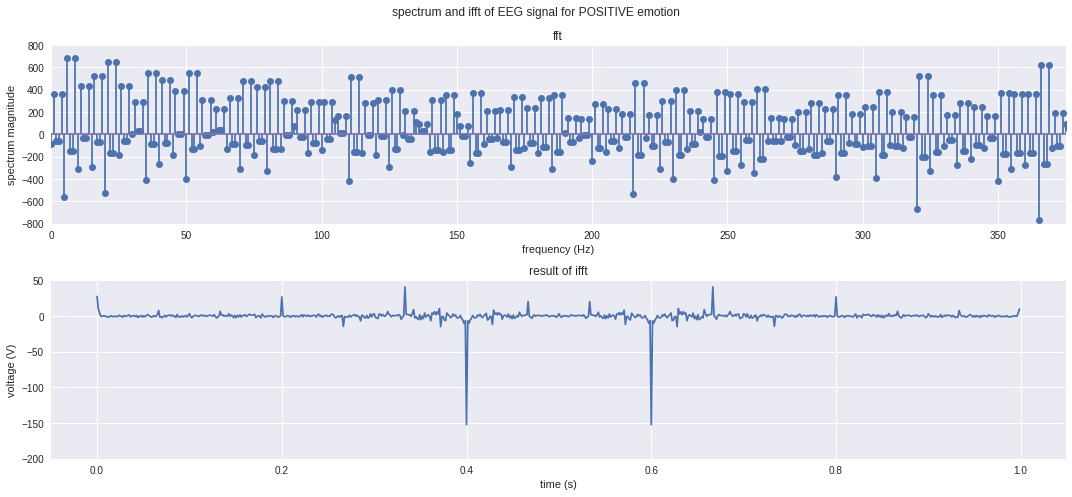

In [9]:
plt.rcParams["figure.figsize"] = (15, 7)
fig, axs = plt.subplots(2, 1)
fig.suptitle('spectrum and ifft of EEG signal for POSITIVE emotion')

axs[0].stem(freq, rows[2])
axs[0].set_xlabel("frequency (Hz)")
axs[0].set_ylabel("spectrum magnitude")
axs[0].title.set_text("fft")
axs[0].set_xlim([0, fs / 2])
axs[0].set_ylim([-800, 800])

axs[1].plot(time, iffts[2])
axs[1].set_xlabel("time (s)")
axs[1].set_ylabel("voltage (V)")
axs[1].title.set_text("result of ifft")
axs[1].set_ylim([-200, 50])

plt.tight_layout()
plt.show()

## Spectrograms
Maybe, some time-frequency analysis will also be helphful with visual understanding difference between EEG signals fot various emotions. Let's check the hypothesis!

/home/sophmintaii/.local/lib/python3.9/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '
/tmp/ipykernel_137998/2853694862.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axs[0].pcolormesh(t, f, Sxx, shading=SHADING)
/tmp/ipykernel_137998/2853694862.py:13: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axs[1].pcolormesh(t, f, Sxx, shading=SHADING)
/tmp/ipykernel_137998/2853694862.py:19: UserWarning: The input coordinates to pcolormesh are interpreted as cell ce

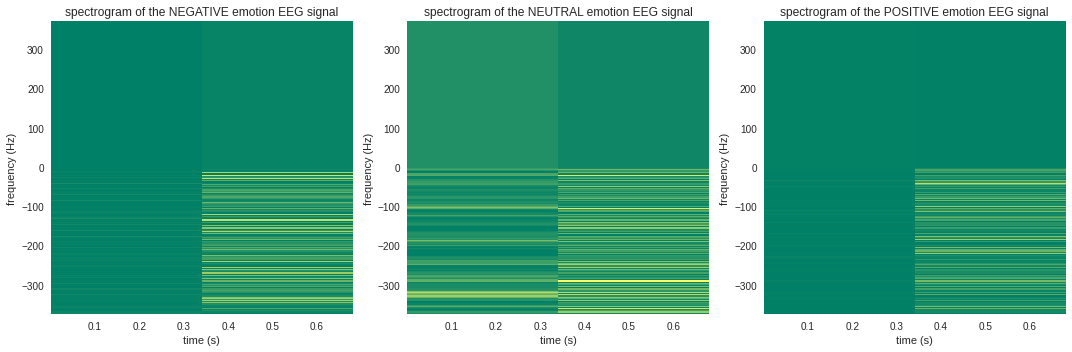

In [10]:
plt.rcParams["figure.figsize"] = (15, 5)
fig, axs = plt.subplots(1, 3)

SHADING = 'auto' # 'gouraud'

f, t, Sxx = signal.spectrogram(iffts[0], fs, noverlap=True)
axs[0].pcolormesh(t, f, Sxx, shading=SHADING)
axs[0].title.set_text(f"spectrogram of the NEGATIVE emotion EEG signal")
axs[0].set_xlabel("time (s)")
axs[0].set_ylabel("frequency (Hz)")

f, t, Sxx = signal.spectrogram(iffts[1], fs, noverlap=True)
axs[1].pcolormesh(t, f, Sxx, shading=SHADING)
axs[1].title.set_text(f"spectrogram of the NEUTRAL emotion EEG signal")
axs[1].set_xlabel("time (s)")
axs[1].set_ylabel("frequency (Hz)")

f, t, Sxx = signal.spectrogram(iffts[2], fs, noverlap=True)
axs[2].pcolormesh(t, f, Sxx, shading=SHADING)
axs[2].title.set_text(f"spectrogram of the POSITIVE emotion EEG signal")
axs[2].set_xlabel("time (s)")
axs[2].set_ylabel("frequency (Hz)")

plt.tight_layout()
plt.show()

## Now, let us do the FFT back, so we can actually use the features for the prediction

In [11]:
def get_fft(signal):
    fft = np.fft.fft(signal)
    fft = [elem.real for elem in fft]
    return fft

In [12]:
ffts = []
for ifft in iffts:
    ffts.append(get_fft(ifft))

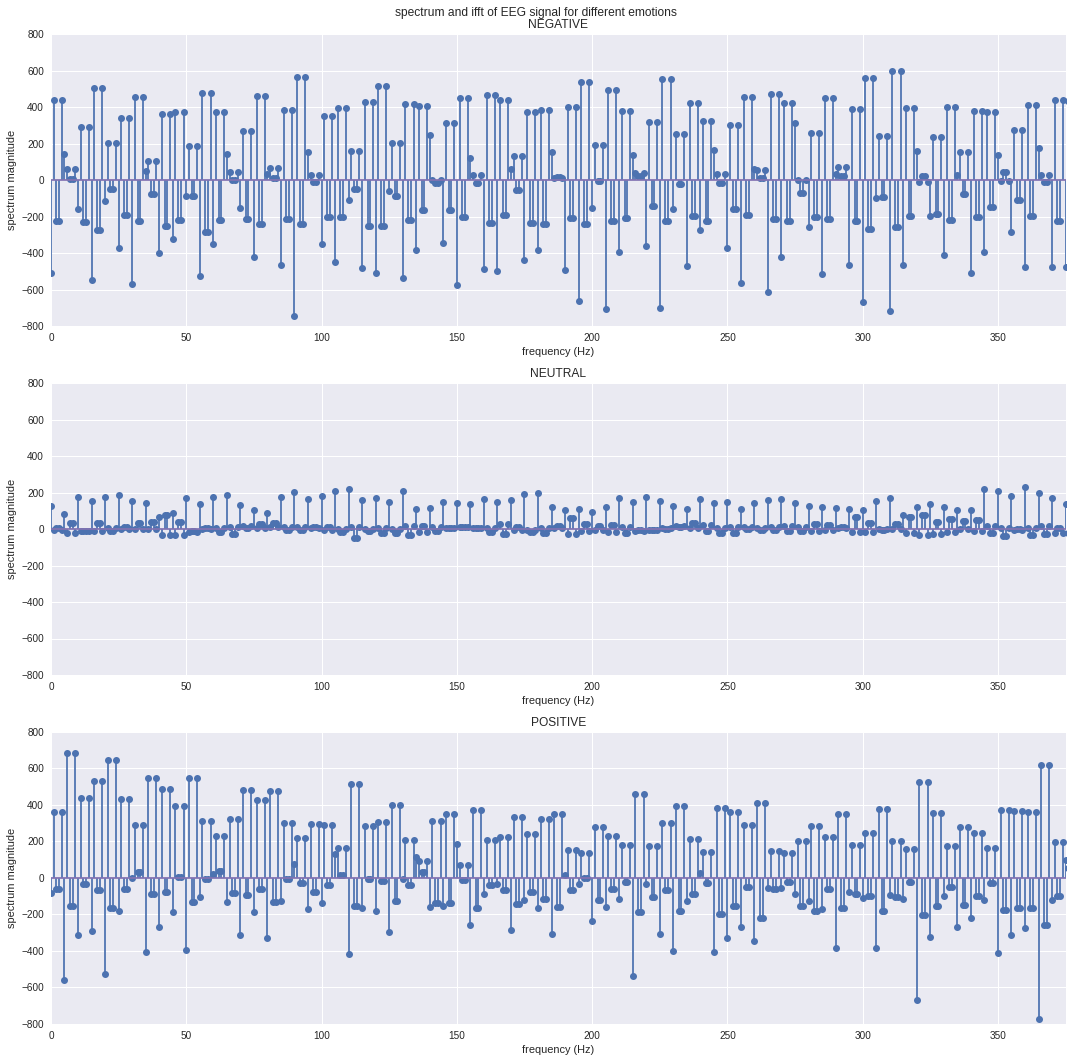

In [13]:
plt.rcParams["figure.figsize"] = (15, 15)
fig, axs = plt.subplots(3, 1)
fig.suptitle('spectrum and ifft of EEG signal for different emotions')

axs[0].stem(freq, ffts[0])
axs[0].set_xlabel("frequency (Hz)")
axs[0].set_ylabel("spectrum magnitude")
axs[0].title.set_text("NEGATIVE")
axs[0].set_xlim([0, fs / 2])
axs[0].set_ylim([-800, 800])

axs[1].stem(freq, ffts[1])
axs[1].set_xlabel("frequency (Hz)")
axs[1].set_ylabel("spectrum magnitude")
axs[1].title.set_text("NEUTRAL")
axs[1].set_xlim([0, fs / 2])
axs[1].set_ylim([-800, 800])

axs[2].stem(freq, ffts[2])
axs[2].set_xlabel("frequency (Hz)")
axs[2].set_ylabel("spectrum magnitude")
axs[2].title.set_text("POSITIVE")
axs[2].set_xlim([0, fs / 2])
axs[2].set_ylim([-800, 800])

plt.tight_layout()
plt.show()

In [14]:

new_ffts = np.array(ffts)
new_data_fft = pd.DataFrame(new_ffts)
new_data_fft.head()

,0,1,2,3,4,5,6,7,8,9,...,740,741,742,743,744,745,746,747,748,749
0,-508.0,438.00,-222.00,-222.00,438.00,143.0,59.40,5.05,5.05,59.40,...,74.3,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00
1,126.0,-4.00,7.42,7.42,-4.00,81.6,-22.30,35.30,35.30,-22.30,...,130.0,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57
2,-85.9,361.00,-62.20,-62.20,361.00,-558.0,684.00,-152.00,-152.00,684.00,...,-534.0,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00
3,69.5,3.89,12.10,12.10,3.89,-188.0,274.00,-200.00,-200.00,274.00,...,-183.0,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40
4,226.0,-27.40,147.00,147.00,-27.40,301.0,-8.48,138.00,138.00,-8.48,...,114.0,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60


Now, let us train KNN classifier and see its performance.

In [15]:
pipeline_knn = Pipeline(steps=[('scaler', MinMaxScaler()),
                             ('knn', KNeighborsClassifier(n_neighbors=3))])

accuracies = cross_val_score(pipeline_knn, new_data_fft, data_labels, cv=10, scoring='accuracy')
accuracy = accuracies.mean()
print(f'Accuracy for KNN with 4 neighbors: {accuracy}')

Accuracy for KNN with 4 neighbors: 0.960137773682594


In [16]:
pipeline_random_forest = Pipeline(steps=[('random_forest', RandomForestClassifier())])

accuracies = cross_val_score(pipeline_random_forest, new_data_fft, data_labels, cv=10, scoring='accuracy')
accuracy = accuracies.mean()
print(f'Accuracy for Random forest: {accuracy}')

Accuracy for Random forest: 0.9352770830591023
